### 課題1
以下の小問の(1)-(5)を解答し，さらに(6)-(9)を1つ以上選択し回答すること．

1. 上記のコードにおける全結合層の順伝搬，逆伝搬の計算方法を説明し，上記のコードを実行せよ．
1. Reluを３層ともFalseにした場合の結果はどうなるか？ 予想して実際に試してみよ．
1. モデルパラメータ（例えば，10->30) を変化させて，結果を比較せよ．(特に最終loss値)
1. 学習率を変化させて挙動を観察せよ．
1. モーメンタムSDGに変更して，ノーマルなSDGとの違いを観察せよ．モーメンタムSDGの実装は各自完成させよ．
1. 関数 $f(x)$ を自由に書き換え，実行せよ．
1. Adam, AdaGrad のどちらか一方，もしくは両方を実装して比較せよ．
1. 一定のepoch数，もしくは一定以下の誤差値で，学習率が段階的に下がるようし，効果を検証せよ．
1. 中間層の活性化関数にReLUに加えて，Sigmoidを追加し，(1)ReLu, (2)Sigmoid (3)活性化関数なし　の３通りを比較せよ．(なお，Sigmoidのbackward は $dEdy=dEdy*self.y*(1-self.y)$ で記述できる．) 

### 【課題1: 任意発展課題】
興味のある人は，例えば，以下のような拡張を行ってみよ．

1. RMSProp,AdaDeltaも実装せよ．
1. mini-batch をループではなくて，dot の代わりに tensordot を使うようにすることすることで，まとめて一回で計算するように拡張せよ．
1. 上記のmini-batch対応を行った後，cupy ライブラリを使って，GPUに対応させよ．
1. Batch Normalization Layerを追加せよ．

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%matplotlib inline
import math
import numpy as np
import matplotlib.pyplot as plt
from IPython import display

In [3]:
# カレントディレクトリの読み込みとカレントディレクトリへの移動
import sys
sys.path.append(f'/content/drive/My Drive/system/')
import os
os.chdir(f'/content/drive/My Drive/system/myanswer')

In [4]:
class Fc:
    def __init__(self, n_in, n_out, relu=True, seed=0):
        self.n_in = n_in
        self.n_out = n_out
        self.relu = relu
        # w,b は全結合層の学習パラメータ．
        # ReLuも全結合の中に含めてあります．
        # ReLU=Trueのときは，Heの初期値．Falseのときは，Xavierの初期値とします．．
        # xは直前のforward計算時の入力値．BPの計算時に必要．
        np.random.seed(seed) # 同じ初期値を再現できるように seed を指定します．
        if relu:
            self.w = np.random.normal(0, math.sqrt(2.0/n_in), (n_out, n_in)) # Heの初期値
            self.relu0 = None # ReLUの順伝搬時に０以下で値が伝搬されない要素のインデックスを記録．BP時に利用．
        else:
            self.w = np.random.normal(0, math.sqrt(1.0/n_in), (n_out, n_in)) # Xavierの初期値   
        self.b = np.zeros((n_out,1))
        self.x = np.zeros((n_in,1))
        #　誤差逆伝搬(Back-Propagation時の勾配を記録する変数)
        self.dEdx = np.zeros((n_in,1)) # dE/dx を表す　BPの時に直前レイヤに伝わる勾配でδと表現されます．
        self.dEdw = np.zeros((n_out,n_in)) # dE/dw を表す
        self.dEdb = np.zeros((n_out,1)) # dE/db を表す
        self.count = 0
        # MomentumSGDの初期設定
        self.mdw = np.zeros((n_out,n_in))
        self.mdb = np.zeros((n_out,1))

        # Adamの初期設定
        self.mw = np.zeros((n_out, n_in))
        self.vw = np.zeros((n_out, n_in))
        self.mb = np.zeros((n_out, 1))
        self.vb = np.zeros((n_out, 1))

        # AdagradとRmspropの初期設定
        self.hw = np.zeros((n_out, n_in))
        self.hb = np.zeros((n_out, 1))

        # Adadeltaの初期設定
        self.mdw_adadelta = np.zeros((n_out, n_in))
        self.mdb_adadelta = np.zeros((n_out, 1))
        self.rw = np.zeros((n_out, n_in))
        self.sw = np.zeros((n_out, n_in))
        self.rb = np.zeros((n_out, 1))
        self.sb = np.zeros((n_out, 1))
      
    # forward は __call__ を使って定義する．単純な 行列＊ベクトル＋ベクトル　の計算．
    def __call__(self,x): 
        self.x = x
        self.y = np.dot(self.w, x) + self.b
        # ReLUは，値が0以下の要素は，0とする．0とした要素のインデックスは relu0に記録し，BP時に勾配を伝搬させない．
        if self.relu:
            self.relu0 = self.y <= 0
            self.y[self.relu0] = 0
        return self.y

    # backward は，dE/dy を受け取って，dE/dx を出力．内部では，dE/dw, dE/db を更新
    def backward(self, dEdy):
          # 順伝搬時に値が０以下だった要素は勾配を０として，勾配伝搬しない．
        if self.relu:
            dEdy[self.relu0] = 0
        dydx = np.transpose(self.w)  # dWx/dx= np.transpose(W) であることより．
        dydw = np.transpose(self.x)  # dWx/dW= np.transpose(x) 
        # dydb = np.ones((self.n_out,1))   #  db/db = np.ones((n_out,1))　１なので特に計算しない．
        # dEdw, dEdb に勾配を加算．dEdx (δ)は前層へ伝搬する勾配で，backwardの返り値とする．
        self.dEdx = np.dot(dydx, dEdy)
        self.dEdw += np.dot(dEdy, dydw)
        self.dEdb += dEdy
        self.count +=1  # 勾配の平均を取るために，足した勾配のサンプル数を記録．
        return self.dEdx

    # 勾配をクリア
    def clear_grad(self):
        self.dEdw = 0
        self.dEdb = 0
        self.count = 0

    # 勾配法で重みをアップデート．countで割って，足しこんだ勾配のサンプル数で平均を取る
    def update(self, lr=0.001):
        self.w -= (self.dEdw/self.count) * lr
        self.b -= (self.dEdb/self.count) * lr
        self.clear_grad()
    
    # 慣性項（モーメンタム項）付きの勾配法(課題1の5)
    def updatem(self, lr=0.001, mu=0.9):
        self.mdw = mu * self.mdw - (self.dEdw/self.count) * lr
        self.mdb = mu * self.mdb - (self.dEdb/self.count) * lr
        self.w += self.mdw
        self.b += self.mdb
        self.clear_grad()
    
    # adam (課題1の7)
    def update_adam(self, lr=0.001, beta1=0.9, beta2=0.99):
        self.mw = beta1 * self.mw + (1 - beta1) * (self.dEdw/self.count)
        self.vw = beta2 * self.vw + (1 - beta2) * (self.dEdw/self.count)**2
        
        self.mb = beta1 * self.mb + (1 - beta1) * (self.dEdb/self.count)
        self.vb = beta2 * self.vb + (1 - beta2) * (self.dEdb/self.count)**2
        
        mhat_w = self.mw / (1 - beta1**self.count)
        vhat_w = self.vw / (1 - beta2**self.count)
        
        mhat_b = self.mb / (1 - beta1**self.count)
        vhat_b = self.vb / (1 - beta2**self.count)
        
        self.w -= lr * mhat_w/(np.sqrt(vhat_w) + 1e-7)
        self.b -= lr * mhat_b/(np.sqrt(vhat_b) + 1e-7)
        
        self.clear_grad()
    
    # adagrad (課題1の7)
    def update_adagrad(self, lr=0.01):
        self.hw += (self.dEdw/self.count)**2
        self.hb += (self.dEdb/self.count)**2
        self.w -= lr * (self.dEdw/self.count)/(np.sqrt(self.hw)+ 1e-7)
        self.b -= lr * (self.dEdb/self.count)/(np.sqrt(self.hb) + 1e-7)
        self.clear_grad()
    
    # rmsprop (課題2の1)
    def update_rmsprop(self, lr=0.01, decay_rate=0.99):
        self.hw *= decay_rate
        self.hb *= decay_rate
        self.hw += (1-decay_rate) * (self.dEdw/self.count)**2 
        self.hb += (1-decay_rate) * (self.dEdb/self.count)**2
        self.w -= lr * (self.dEdw/self.count)/(np.sqrt(self.hw)+ 1e-7)
        self.b -= lr * (self.dEdb/self.count)/(np.sqrt(self.hb) + 1e-7)
        self.clear_grad()

    # adadelta (課題2の1)
    def update_adadelta(self, gamma=0.9):
        self.rw = gamma * self.rw + (1 - gamma) * (self.dEdw/self.count)**2
        self.rb = gamma * self.rb + (1 - gamma) * (self.dEdb/self.count)**2         
        
        self.mdw_adadelta = (np.sqrt(self.sw + 1e-7)) * (self.dEdw/self.count) /(np.sqrt(self.rw + 1e-7))
        self.mdb_adadelta = (np.sqrt(self.sb + 1e-7)) * (self.dEdb/self.count) /(np.sqrt(self.rb + 1e-7))
        
        self.sw = gamma * self.sw + (1 - gamma) * self.mdw_adadelta ** 2   
        self.sb = gamma * self.sb + (1 - gamma) * self.mdb_adadelta ** 2

        self.w -= self.mdw_adadelta
        self.b -= self.mdb_adadelta
        
        self.clear_grad()

In [5]:
def f(x):
    return 0.5*(x-2)**2-5

def generate_data(f):
    X_train = np.arange(-10,10,0.01,dtype=np.float32)
    Y_train = f(X_train)

    # X_train, Y_trainは１次元配列なので，reshapeで ２次元の(n,dim)に変換します．dim=1です．
    X_train = np.reshape(X_train,[-1,1])   # (2000,)  -> (2000,1)
    Y_train = np.reshape(Y_train,[-1,1]) 
    num_train = np.size(X_train)

    # テスト用の x も準備します．
    X_val = np.arange(-8,8,0.1,dtype=np.float32)
    Y_val = f(X_val)
    X_val = np.reshape(X_val,[-1,1])
    Y_val = np.reshape(Y_val,[-1,1])
    num_val = np.size(X_val)
    return X_train, Y_train, X_val, Y_val, num_train, num_val

In [6]:
def show_learning_result(f, fc1, fc2, fc3, X_train, Y_train, X_val, Y_val, 
                         num_train, num_val, lr=0.001, mu=0.9, decay_rate=0.99, beta1=0.9, beta2=0.99, gamma=0.9,
                         num_epoch=150, num_batch=100, optimizer="sgd", is_relu=True, param_pattern="1", function_pattern="1"):
    """
    f: 関数
    fc1: 全結合層の1層目
    fc2: 全結合層の2層目
    fc3: 全結合層の3層目
    X_train: 学習データの実数値
    Y_train: 関数f にX_trainを代入した際の実数値
    X_val: 検証データの実数値
    Y_val: 関数f にX_valを代入した際の実数値
    num_train(int): 学習データのデータ点の数
    num_val(int): 検証データのデータ点の数
    lr(float): 学習率
    mu(float): 慣性項の係数 momentum_sgdで使用
    decay_rate(float): rmspropで利用するパラメータ
    beta1(float): adamで利用するパラメータ
    beta2(float): adamで利用するパラメータ
    gamma(float): adadeltaで利用するパラメータ
    num_epoch(int): エポック数
    num_batch(int): ミニバッチ数
    optimizer(list): 勾配の最適化方法 ["sgd", "momentum_sgd", "adam", "adagrad", "rmsprop", "adadelta"]という文字列を代入することを想定
    is_relu(bool): reluを使うかどうか(使う:True，使わない:False)にするかどうか 結果の画像を保存するために利用
    param_pattern(str): 全結合層のパラメータの設定パターン 以下の3パターンを想定．結果の画像を保存するために利用 
     1: fc1 = Fc(1,20)，fc2 = Fc(20,20)，fc3 = Fc(20,1)
     2: fc1= Fc(1,20)，fc2 = Fc(20,100)，fc3= Fc(100,1)
     3: fc1 = Fc(1,20)，fc2 = Fc(20,5)，fc3 = Fc(5,1)
    function_pattern(str): f(x)を使うかf2(x)にするか 1ならば，f(x)．2ならば，f2(x) 結果の画像を保存するために利用
    """
    
    x0 = np.reshape(X_val,[-1])
    losses = np.array([])
    losses_val = np.array([])
    ep = np.array([])
    # 表示エリアの設定
    fig = plt.figure()
    fig1 = fig.add_subplot(121)
    fig2 = fig.add_subplot(122)
    for epoch in range(num_epoch):
    # Stochastic Gradient Descent なので，epochごとに学習データをシャッフルします．
        shuffler = np.random.permutation(num_train)
        X_train = X_train[shuffler]
        Y_train = Y_train[shuffler]
        for n in range(0, num_train, num_batch):
            loss = 0
            for i in range(num_batch):
                # 順伝搬計算
                y = fc3(fc2(fc1(np.c_[X_train[n+i]])))
                # 誤差微分値，誤差値を計算します． 
                dEdx = y - np.c_[Y_train[n+i]]
                loss += (dEdx**2)*0.5
                # dEdx (δ)を計算して，逆伝搬します．
                dEdx = fc3.backward(dEdx)
                dEdx = fc2.backward(dEdx)
                dEdx = fc1.backward(dEdx)
            # minibatch の順伝搬，逆伝搬を行ったら，SDGで重みを更新
            if optimizer == "sgd":
                fc1.update(lr)
                fc2.update(lr)
                fc3.update(lr)
            elif optimizer == "momentum_sgd":
                fc1.updatem(lr, mu)
                fc2.updatem(lr, mu)
                fc3.updatem(lr, mu)
            elif optimizer == "adam":
                fc1.update_adam(lr, beta1, beta2)
                fc2.update_adam(lr, beta1, beta2)
                fc3.update_adam(lr, beta1, beta2)
            elif optimizer == "adagrad":
                fc1.update_adagrad(lr=0.01)
                fc2.update_adagrad(lr=0.01)
                fc3.update_adagrad(lr=0.01)
            elif optimizer == "rmsprop":
                fc1.update_rmsprop(lr=0.01)
                fc2.update_rmsprop(lr=0.01)
                fc3.update_rmsprop(lr=0.01)
            elif optimizer == "adadelta":
                fc1.update_adadelta(gamma)
                fc2.update_adadelta(gamma)
                fc3.update_adadelta(gamma)

            
            # 各epochの最初にグラフ表示を行います．
            if n == 0:
                losses = np.append(losses,loss/num_batch)
                ep = np.append(ep,epoch)
                # 検証用データの評価
                loss_val = 0
                Y_pred = np.array([])
                for i in range(num_val):
                    # 順伝搬計算
                    y = fc3(fc2(fc1(np.c_[X_val[i]])))
                    Y_pred = np.append(Y_pred,y)
                    # 誤差微分値，誤差値 
                    dEdx = y - np.c_[Y_val[i]]
                    loss_val += (dEdx**2) * 0.5    
                losses_val = np.append(losses_val, loss_val/num_val)

                display.clear_output(wait = True)
                fig1.axis([0, num_epoch, 0, 50])
                fig1.plot(ep,losses,"b",label="train loss")
                fig1.plot(ep,losses_val,"r", label="validation loss")
                fig1.legend(loc="upper right")
                
                fig2.axis([-8,8,-10,30])
                y0 = np.reshape(Y_pred,[-1])
                fig2.plot(x0,y0,"b", label="approximated function")
                fig2.plot(x0,f(x0),"r", label="original function")
                fig2.legend(loc="upper right")
                display.display(fig)
                if epoch < num_epoch-1:
                    fig1.cla()
                    fig2.cla()

    display.clear_output(wait = True)
    os.makedirs('../result/fullconnection_scratch/', exist_ok=True)
    fig.savefig("../result/fullconnection_scratch/{}_lr{}_relu{}_function{}_param{}.png".format(optimizer, lr, str(is_relu), function_pattern, param_pattern),
                transparent=True, dpi=300, bbox_inches="tight", pad_inches=0.0)
    print("loss_val: {}".format(loss_val))

### 課題1.1上記のコードにおける全結合層の順伝搬，逆伝搬の計算方法を説明し，上記のコードを実行せよ．
コードの説明をする

In [7]:
fc1 = Fc(1,20)
fc2 = Fc(20,20)
fc3 = Fc(20,1)

loss_val: [[1105.2294272]]


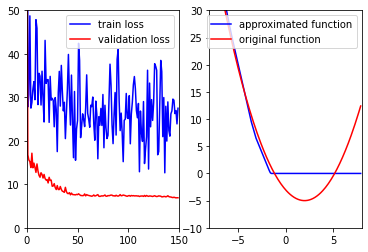

In [8]:
X_train, Y_train, X_val, Y_val, num_train, num_val = generate_data(f)
show_learning_result(f, fc1, fc2, fc3, X_train, Y_train, X_val, Y_val, num_train, num_val)

### 課題1.2 Reluを３層ともFalseにした場合の結果はどうなるか？ 予想して実際に試してみよ．

Relu関数は識別関数を非線形にする作用がある．
そのため，活性化関数として，Relu関数を使わない場合(Falseにした場合)，識別関数が線形，つまり直線になる．<br>
また，学習データと検証データの誤差が縮まることはなく，差が大きくなっていく<br>
と予想．

loss_val: [[10695.93438748]]


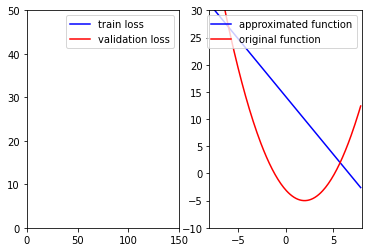

In [9]:
# Reluを3層ともすべてFalseにする
fc1_activation_false = Fc(1,20, False)
fc2_activation_false = Fc(20,20, False)
fc3_activation_false = Fc(20,1,False)
show_learning_result(f, fc1_activation_false, fc2_activation_false, fc3_activation_false, 
                     X_train, Y_train, X_val, Y_val, num_train, num_val, is_relu=False)

### 課題1.3 モデルパラメータ（例えば，10->30) を変化させて，結果を比較せよ．(特に最終loss値)

loss_val: [[19279.07189467]]


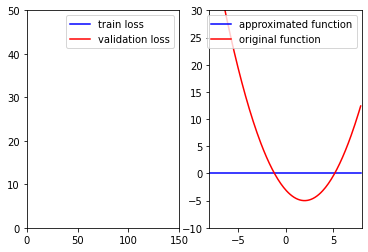

In [10]:
fc1_changed = Fc(1,20)
fc2_changed = Fc(20,100)
fc3_changed = Fc(100,1)
show_learning_result(f, fc1_changed, fc2_changed, fc3_changed, X_train, Y_train, X_val, Y_val, num_train, num_val, param_pattern="2")

loss_val: [[1146.6879902]]


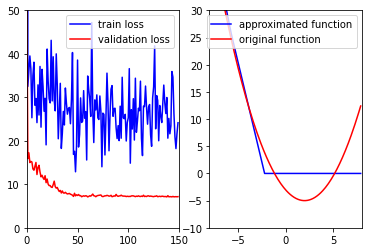

In [11]:
fc1_changed = Fc(1,20)
fc2_changed = Fc(20,5)
fc3_changed = Fc(5,1)
show_learning_result(f, fc1_changed, fc2_changed, fc3_changed, X_train, Y_train, X_val, Y_val, num_train, num_val, param_pattern="3")

### 課題1 4. 学習率を変化させて挙動を観察せよ．

loss_val: [[19279.07189467]]


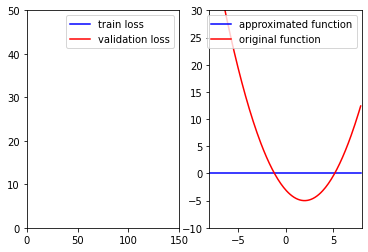

In [12]:
fc1 = Fc(1,20)
fc2 = Fc(20,20)
fc3 = Fc(20,1)
# デフォルトの値0.001よりも学習率を高くする
show_learning_result(f, fc1, fc2, fc3, X_train, Y_train, X_val, Y_val, num_train, num_val, lr=0.1)

loss_val: [[1020.12138186]]


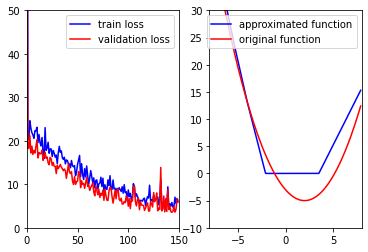

In [13]:
fc1 = Fc(1,20)
fc2 = Fc(20,20)
fc3 = Fc(20,1)
# デフォルトの値0.001よりも学習率を低くする
show_learning_result(f, fc1, fc2, fc3, X_train, Y_train, X_val, Y_val, num_train, num_val, lr=0.0005)

### 課題1.5 モーメンタムSDGに変更して，ノーマルなSDGとの違いを観察せよ．モーメンタムSDGの実装は各自完成させよ．

ノーマルなSGDは課題1.1の結果を参照

loss_val: [[1066.24885913]]


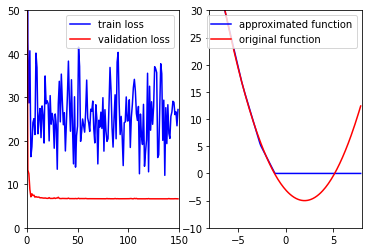

In [14]:
fc1 = Fc(1,20)
fc2 = Fc(20,20)
fc3 = Fc(20,1)
show_learning_result(f, fc1, fc2, fc3, X_train, Y_train, X_val, Y_val, num_train, num_val, optimizer="momentum_sgd")

### 課題1 6 関数  𝑓(𝑥)  を自由に書き換え，実行せよ．
$f_{2}(x)=\dfrac{1}{2}(x+3)^{2}-8$，最適化手法はSGDとする．

loss_val: [[1539.45805194]]


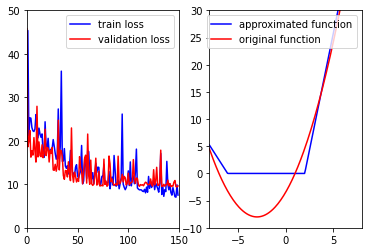

In [15]:
fc1 = Fc(1,20)
fc2 = Fc(20,20)
fc3 = Fc(20,1)

def f2(x):
    return 0.5*(x + 3)**2 - 8

X_train_f2, Y_train_f2, X_val_f2, Y_val_f2, num_train_f2, num_val_f2 = generate_data(f2)
show_learning_result(f2, fc1, fc2, fc3, X_train_f2, Y_train_f2, X_val_f2, Y_val_f2, num_train_f2, num_val_f2, function_pattern="2")

### 課題1.7 Adam, AdaGrad のどちらか一方，もしくは両方を実装して比較せよ．

関数は$f(x)=\dfrac{1}{2}(x-2)^2 -5$，モデルのパラメータは課題1.1と同じとする．

* Adamを適用した場合

loss_val: [[466.88484118]]


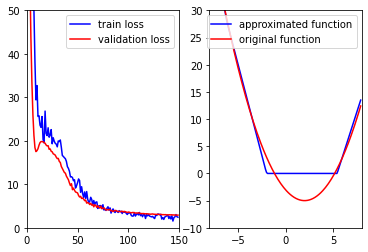

In [16]:
fc1 = Fc(1,20)
fc2 = Fc(20,20)
fc3 = Fc(20,1)
show_learning_result(f, fc1, fc2, fc3, X_train, Y_train, X_val, Y_val, num_train, num_val, optimizer="adam")

* Adagradを適用した場合

loss_val: [[944.90722459]]


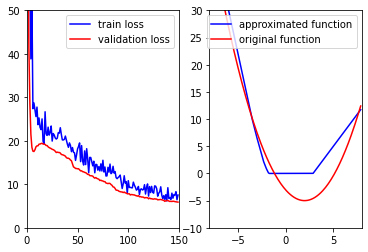

In [17]:
fc1 = Fc(1,20)
fc2 = Fc(20,20)
fc3 = Fc(20,1)
show_learning_result(f, fc1, fc2, fc3, X_train, Y_train, X_val, Y_val, num_train, num_val, optimizer="adagrad")

### 【課題1: 任意発展課題】
1. RMSProp,AdaDeltaも実装せよ．

* RMSPropを適用．関数は$f(x)=\dfrac{1}{2}(x-2)^2 -5$，モデルのパラメータは課題1.1と同じとする．

loss_val: [[527.69670679]]


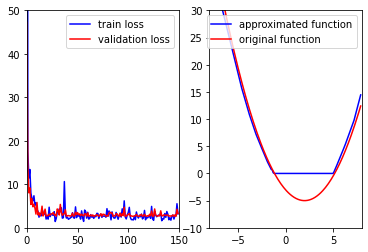

In [18]:
fc1 = Fc(1,20)
fc2 = Fc(20,20)
fc3 = Fc(20,1)
show_learning_result(f, fc1, fc2, fc3, X_train, Y_train, X_val, Y_val, num_train, num_val, optimizer="rmsprop")

* AdaDeltaを適用． 関数は$f(x)=\dfrac{1}{2}(x-2)^2 -5$，モデルのパラメータは課題1.1と同じとする．

loss_val: [[431.5426717]]


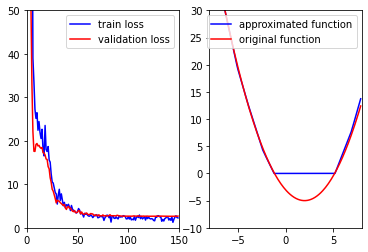

In [19]:
fc1 = Fc(1,20)
fc2 = Fc(20,20)
fc3 = Fc(20,1)
show_learning_result(f, fc1, fc2, fc3, X_train, Y_train, X_val, Y_val, num_train, num_val, optimizer="adadelta")